# Importing Dependencies

In [42]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Prophet library
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# 1. Generalized Additive Models (GAMs)

A business time series exhibits trend, seasonality, and holiday effects. It is well characterized by GAMs, which consider a time series to consist of three components: a linear trend, a seasonal effect, and any holiday effect. GAMs were originally invented by Trevor Hastie and Robert Tibshirani in 1986 [1]. The idea of GAMs is intuitive:

- Relationships between the individual predictors and the dependent variable follow smooth patterns that can be linear or nonlinear.
- Additive: these smooth relationships can be estimated simultaneously and then added up.

GAMs have the following components:

$$
Y(t) = T(t) + S(t) + H(t) + \epsilon (t)
$$

- $T(t)$: Trend;
- $S(t)$: Seasonality for weekly, monthly, and yearly seasonality;
- $H(t)$: Holiday Effects for the effects of holidays that occur on potentially irregular schedules over one or more days;
- $\epsilon (t)$ is for any idiosyncratic changes that are not accommodated by the model. This often interpreted as the error term and in most cases it is assumed to follow a normal distribution;

## 1.1. GAMs with Prophet

Prophet is an open-source library for time series by Facebook. Prophet is widely used because it is intuitive, easy to use, and has great visualization tools. Data scientists and engineers who need to build forecasting models quickly will find it very helpful.

The `daily-website-visitors` dataset is about the number of visitors to an academic teaching notes website from Kaggle.com. This dataset has daily counts of page loads, unique visitors, first-time visitors, and returning visitors. The dataset covers the date range from September 14, 2014, to August 19, 2020.

### 1.1.1. Data Processing

In [21]:
# Defining local path to dataset
path = '../data/{dataset_name}'

# Reading dataset
df = pd.read_csv(path.format(dataset_name="daily-website-visitors.csv"), thousands=',')

# Printing first 3 rows
df.head(3)

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278


**Prophet is a tool for univariate time series**. It requires two columns with the names ds and y.

In [22]:
# Convert string to datetime64
df["Date"] = pd.to_datetime(df["Date"])

# Selecting only the columns we need
df = df[['First.Time.Visits', 'Date']]

# Renaming columns         
df.columns = ['y', 'ds']
              
# Converting the number of first time visits to numeric
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Selecting only data after 2017
df = df[df['ds'] >= pd.to_datetime('2017-01-01')]

# Sorting by date
df = df.sort_values(by='ds').reset_index()
                    
# Printing first 3 rows
df.head(3)

,index,y,ds
0,840,832,2017-01-01
1,841,1448,2017-01-02
2,842,1970,2017-01-03


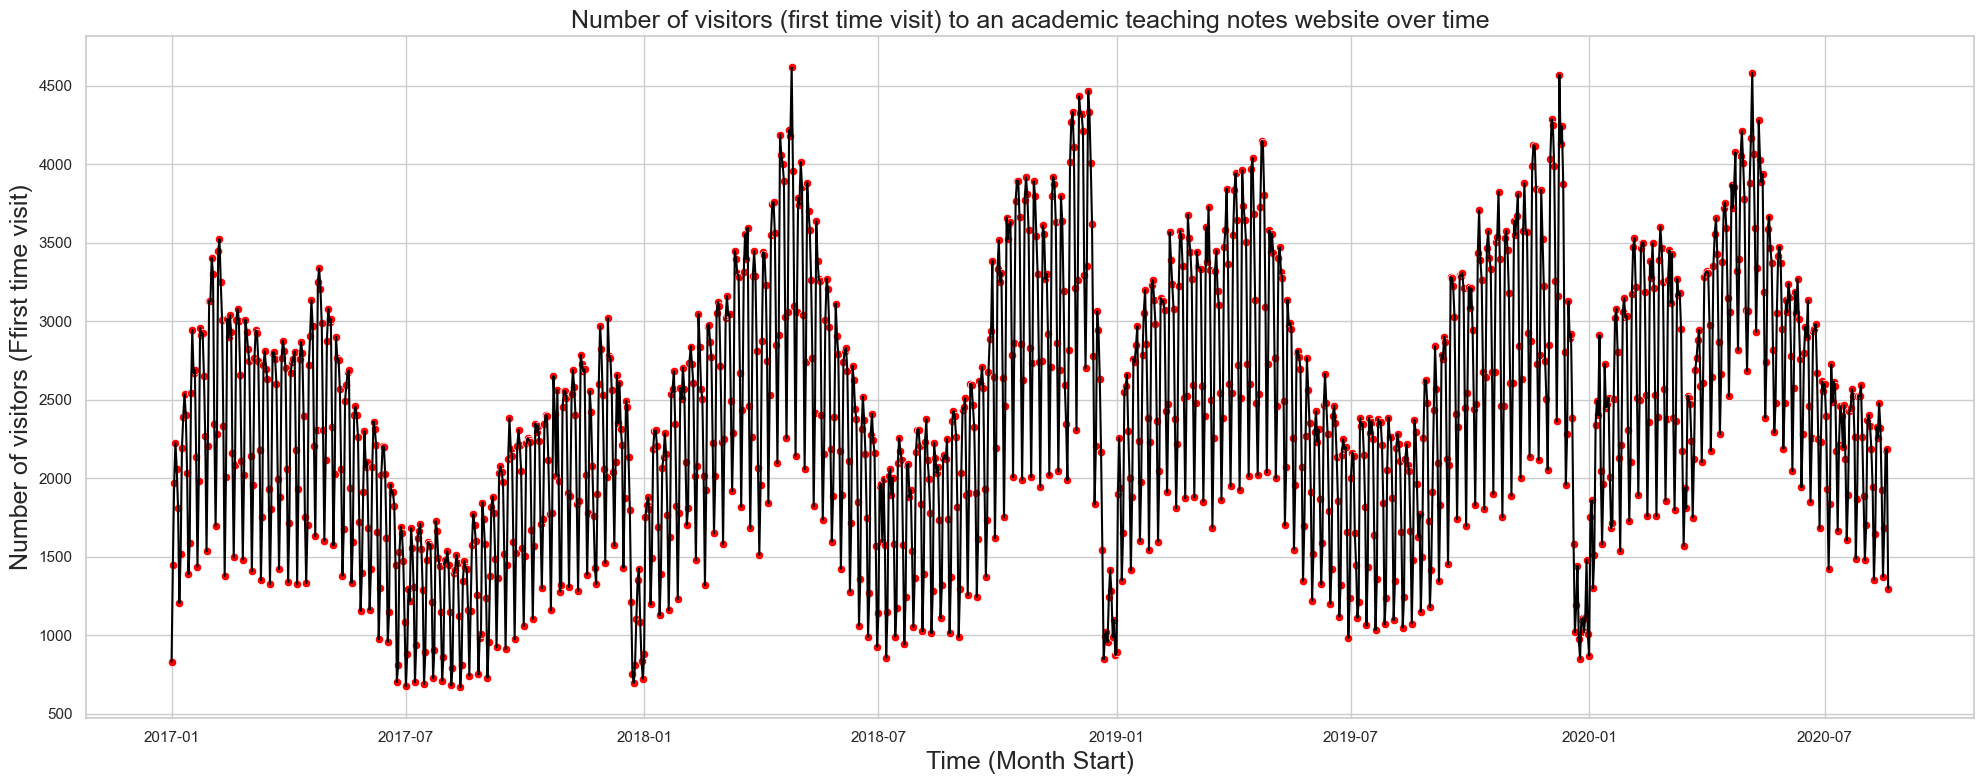

In [33]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(data=df, x="ds", y="y", color="red")
sns.lineplot(data=df, x="ds", y="y", color="black")
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of visitors (Ffirst time visit)', fontsize=18)
plt.title('Number of visitors (first time visit) to an academic teaching notes website over time', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

Time series modeling typically uses in-time (training set) and out-of-time (test set) data for model training and testing to build a model. The parameters of the model is estimated using the in-time data and the model is then evaluated using the out-of-time data. Since the data has a time structure, we cannot randomly split the dataset. Instead, we define a cutoff date and set the data prior to the cutoff date as the in-time data (training set) and the data after the cutoff date as the out-of-time data (test set).
For the puporse of the exercise, **the cutoff date will be set to 2020–02–01**.


In [36]:
# Training data
tr_df = df[df['ds'] <= pd.to_datetime('2020-02-01')]

# Testing data
tt_df = df[df['ds']  > pd.to_datetime('2020-02-01')]

### 1.1.2. Fitting the data to a Prophet model

In [43]:
# Creating a Prophet model object
m = Prophet()

# Adding US holidays
m.add_country_holidays(country_name='US')

# Fit: Fitting with default parameters
m.fit(tr_df)

# Future: Generate data points for the future period
future= m.make_future_dataframe(periods=tt_df.shape[0], freq='d')

# Show the last 5 rows of the future dataframe                                
future.tail()

18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing


,ds
1322,2020-08-15
1323,2020-08-16
1324,2020-08-17
1325,2020-08-18
1326,2020-08-19


In [44]:
# Forecast: Apply the model to forecast the future data points
forecast=m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1322,2020-08-15,2520.448667,522.023504,1312.053173,2345.032827,2736.425655,0.0,0.0,0.0,0.0,...,-919.178791,-919.178791,-919.178791,-685.001872,-685.001872,-685.001872,0.0,0.0,0.0,916.268005
1323,2020-08-16,2520.360098,1007.072231,1741.430358,2343.778447,2737.646462,0.0,0.0,0.0,0.0,...,-469.819035,-469.819035,-469.819035,-677.544571,-677.544571,-677.544571,0.0,0.0,0.0,1372.996491
1324,2020-08-17,2520.271528,1878.265019,2689.166024,2342.524066,2739.574017,0.0,0.0,0.0,0.0,...,425.117208,425.117208,425.117208,-670.074228,-670.074228,-670.074228,0.0,0.0,0.0,2275.314508
1325,2020-08-18,2520.182959,1964.224658,2718.446806,2341.269686,2741.431700,0.0,0.0,0.0,0.0,...,472.940813,472.940813,472.940813,-662.613406,-662.613406,-662.613406,0.0,0.0,0.0,2330.510366
1326,2020-08-19,2520.094389,1918.066796,2658.905796,2340.015305,2743.289383,0.0,0.0,0.0,0.0,...,435.699464,435.699464,435.699464,-655.154461,-655.154461,-655.154461,0.0,0.0,0.0,2300.639393


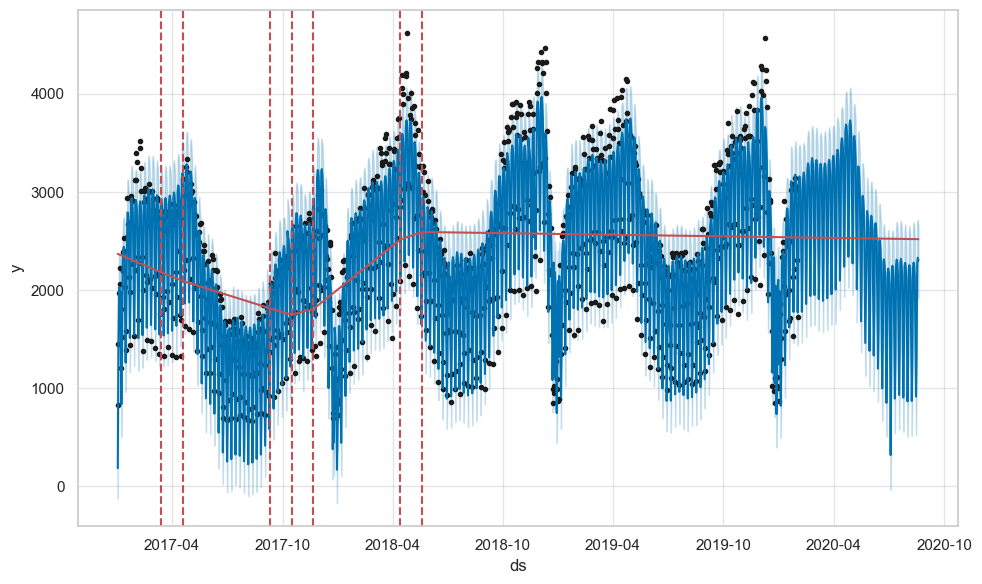

In [ ]:
# Visualizong the forecast using the Prophet changepoints plot
# A change point in a time series refers to a point in time at which the statistical properties of the series, such as the mean, variance, or autocorrelation, change significantly.
fig= m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Plotting model components:
- Trend;
- Holidays;
- Weekly seasonality;
- Yearly seasonality;

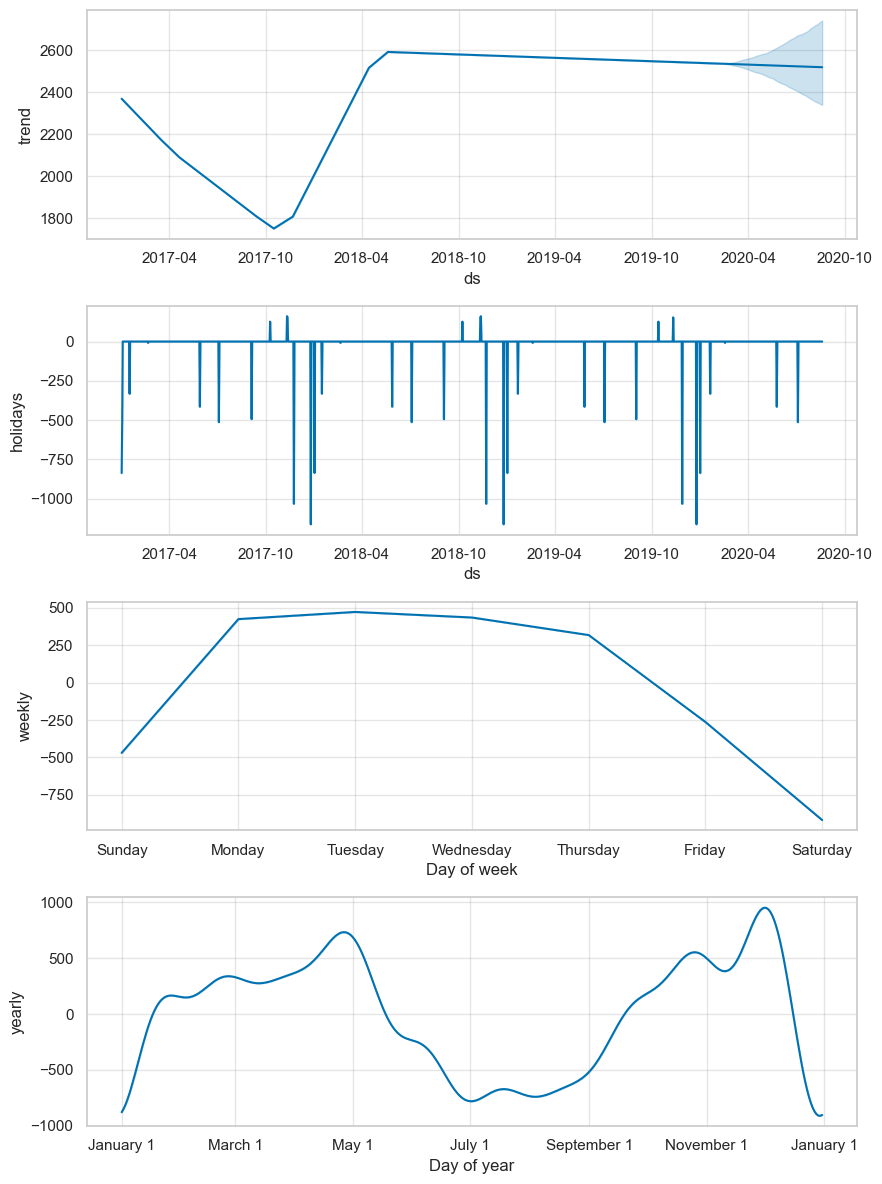

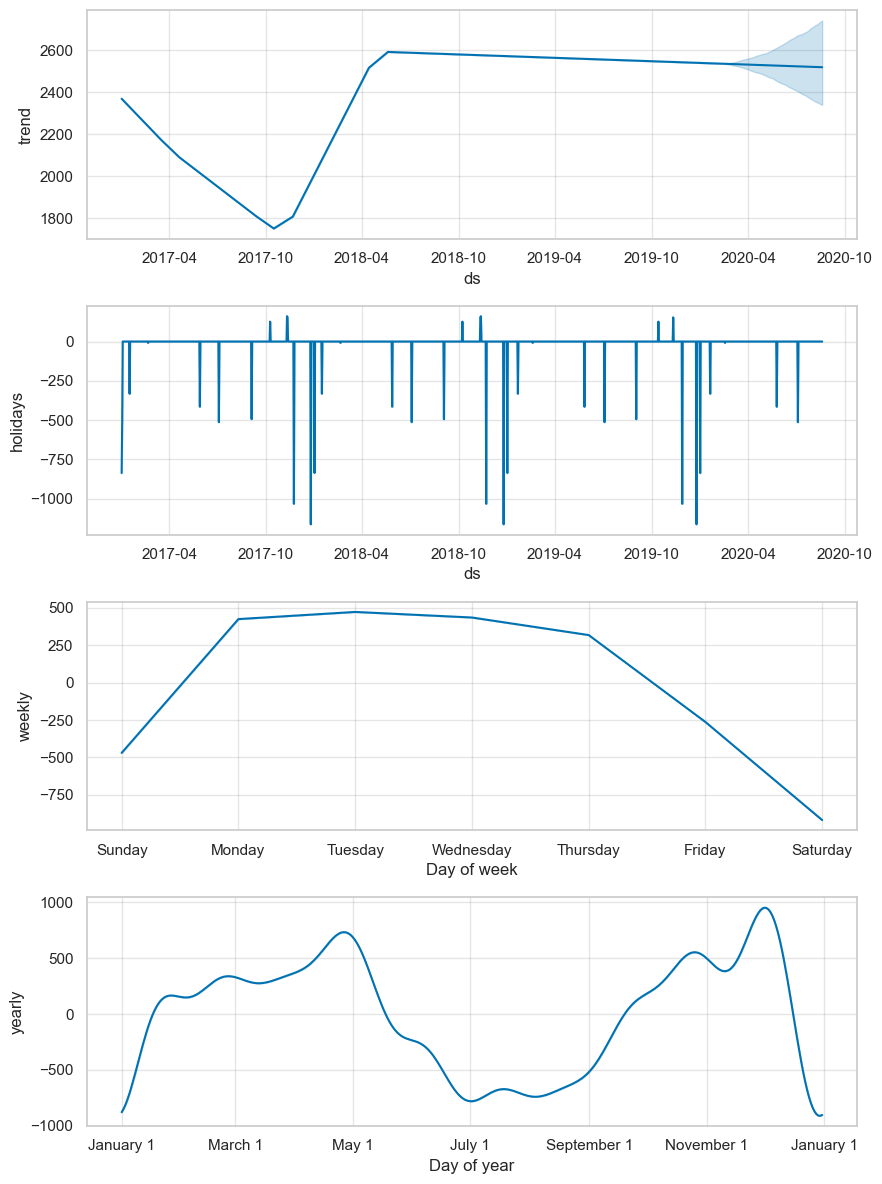

In [47]:
m.plot_components(forecast)